In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import datetime as dt

sys.path.append('../')
from functions.dain import Adaptive_Normalizer_Layer
from functions.adaptive_normalization import process
from functions.fit_one_cycle import OneCycleScheduler
from functions.lr_finder import LRFinder

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
import tensorflow_probability as tfp


from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# .filter(regex=r'^(?!news_.*$)|(?=.*news__High|news__Medium)')

df_1T = pd.read_parquet('df_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True)
df_5T = pd.read_parquet('df_5T.parquet')
df_15T = pd.read_parquet('df_15T.parquet')
df_1H = pd.read_parquet('df_1H.parquet')
df_4H = pd.read_parquet('df_4H.parquet')
df_1B = pd.read_parquet('df_1B.parquet')

In [10]:
# Define the data generator function
def normalize_and_yield(batch_data, batch_targets):
    # Convert to np.array
    batch_data = np.asarray(batch_data)
    batch_targets = np.asarray(batch_targets)
    
    # Normalize
    cols_to_standardize = [c for c in df_1B.columns if any([s in c for s in ['open', 'high', 'low', 'close']])]
    cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]

    for i in range(batch_data.shape[0]):
        a = batch_data[i, :, :, cols_to_standardize]
        scaler = StandardScaler()
        batch_data[i, :, :, cols_to_standardize] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])

    batch_data = batch_data.astype('float32')
    batch_data = np.split(batch_data, 6, axis=1)
    batch_data = [element.squeeze(axis=1) for element in batch_data]

    return np.asarray(batch_data).astype('float32'), batch_targets.astype('float32')


def data_generator(data, window_size, batch_size, indices):
    batch_data = []
    batch_targets = []
    i=0
    for index in indices:
        dt_index = df_1T.iloc[index].name
        
        input_sequences = np.array([
            df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-window_size:].fillna(0).drop(columns='index').values.astype('float32'),
            df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-window_size:].fillna(0).values.astype('float32'),
            df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-window_size:].fillna(0).values.astype('float32'),
            df_1H.loc[:dt_index-pd.Timedelta(hours=1)][-window_size:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-window_size:].fillna(0).values.astype('float32'),
            df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-window_size:].fillna(0).values.astype('float32')
        ])

        # Extract the target high and low values
        dt_index_noon = dt_index.replace(hour=12, minute=0, second=0)
        dt_index_market_close = dt_index.replace(hour=16, minute=0, second=0)
        
        #high_time = df_1T[dt_index : dt_index_noon].high_es.idxmax().replace(tzinfo=None)
        #low_time = df_1T[dt_index : dt_index_noon].low_es.idxmin().replace(tzinfo=None)
        
        #high_time = int((high_time  - high_time.replace(hour=9, minute=30)).total_seconds() // 60)
        #low_time = int((low_time  - low_time.replace(hour=9, minute=30)).total_seconds() // 60)
        
        targets = [
        
        #high_time,
        #low_time,
        df_1T[dt_index : dt_index_noon].high_es.max(), #morning
        df_1T[dt_index : dt_index_noon].low_es.min(),
        df_1T[dt_index : dt_index_noon].high_nq.max(),
        df_1T[dt_index : dt_index_noon].low_nq.min(),
        df_1T[dt_index : dt_index_market_close].high_es.max(), #daily
        df_1T[dt_index : dt_index_market_close].low_es.min(),
        df_1T[dt_index : dt_index_market_close].high_nq.max(),
        df_1T[dt_index : dt_index_market_close].low_nq.min(),
            
        ]


        # Add the input sequence and targets to the batch
        batch_data.append(input_sequences)
        batch_targets.append(targets)
        print(i, len(indices)) if i % 256 == 0 else None
        i += 1
        
    return normalize_and_yield(batch_data, batch_targets)


                
# Set the window size and batch size
window_size = 90 # minutes
batch_size = 64
num_features = df_1B.shape[1]

# Get the indices for training, validation, and testing splits
# Filter the indices to exclude those with insufficient historical data
data_indices = df_1T.loc[(df_1T.index.hour == 9) & (df_1T.index.minute == 30) & (df_1T.index.dayofweek < 5) & (df_1T['index'] > df_1T[df_1B[:window_size+1].iloc[-1].name:].iloc[0]['index'].astype(int))]['index'].to_numpy()
X, y = data_generator(df_1T, window_size, batch_size, data_indices)

#y = pd.read_csv('targets.csv').values

separate_nq = 0
if separate_nq:
    X_nq = X
    X_nq[:, :, :, [0,1,2,3,7,8,9,10]] = X_nq[:, :, :, [7,8,9,10,0,1,2,3]]
    X = np.concatenate([X, X_nq], axis=1)

    y_nq = y[:,2:]
    y = np.concatenate([y[:,:2], y_nq])

0 3597
256 3597
512 3597
768 3597
1024 3597
1280 3597
1536 3597
1792 3597
2048 3597
2304 3597
2560 3597
2816 3597
3072 3597
3328 3597
3584 3597


## Shuffle Indices

In [20]:
# read the y-values from the saved csv file

# Get the total number of samples and calculate the split index
num_samples = X.shape[1]
train_ratio = 0.9
split_index = int(num_samples * train_ratio)

# Shuffle the indices
np.random.seed(42)
shuffle = 1
indices = np.random.permutation(np.arange(num_samples)) if shuffle else np.arange(num_samples)

# Split the array based on the shuffled indices
X_train = list(X[:, indices[:split_index], :, :])
y_train = y[indices[:split_index]]
X_test = list(X[:, indices[split_index:], :, :])
y_test = y[indices[split_index:]]

## Normalize

In [13]:
# Reshape X_train to a np array
X_train = np.asarray(X_train)

# only get columns we want to standardize
cols_to_standardize = [c for c in df_1B.columns if any([s in c for s in ['open', 'high', 'low', 'close']])]
cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]
a = X_train[:,:,:,cols_to_standardize]

# Fit the scaler to the data and transform X_train
scaler = StandardScaler()
X_train[:,:,:,cols_to_standardize] = scaler.fit_transform(a.reshape((-1, a.shape[-1]))).reshape(a.shape)

X_train = np.split(np.array(X_train), 6, axis=1)
X_train = [element.squeeze(axis=1) for element in X_train]

with open('StandardScaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [21]:

cols_without_nq_ym = [df_1B.columns.get_loc(c) for c in [c for c in df_1B.columns if not c.endswith(('_nq', '_ym')) and not c.startswith('news_')]]
cols_without_es_ym = [df_1B.columns.get_loc(c) for c in [c for c in df_1B.columns if not c.endswith(('_es', '_ym')) and not c.startswith('news_')]]
cols_without_es_nq = [df_1B.columns.get_loc(c) for c in [c for c in df_1B.columns if not c.endswith(('_nq', '_ym')) and not c.startswith('news_')]]
cols_with_news = [df_1B.columns.get_loc(c) for c in [c for c in df_1B.columns if c.startswith('news_')]]

In [22]:
X_train_1 = list(np.array(X_train)[:, :, :, cols_without_nq_ym])
num_features = X_train_1[0].shape[-1]

In [23]:
# Define the Transformer model

# Define the input layer
main_inputs = [

    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size),
    Input(shape=(window_size, num_features), batch_size=batch_size)

]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inp in zip(timeframes, main_inputs):
    x = Dense(100, activation='relu')(inp)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    conv_outputs.append(x)
    
# Concatenate the output
output = Concatenate(axis=1)(conv_outputs)
#output = GlobalAveragePooling1D()(output)
output = Dense(1)(output)

# Define the model with two outputs
model = Model(inputs=main_inputs, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mae', metrics=['mse'], run_eagerly=False)

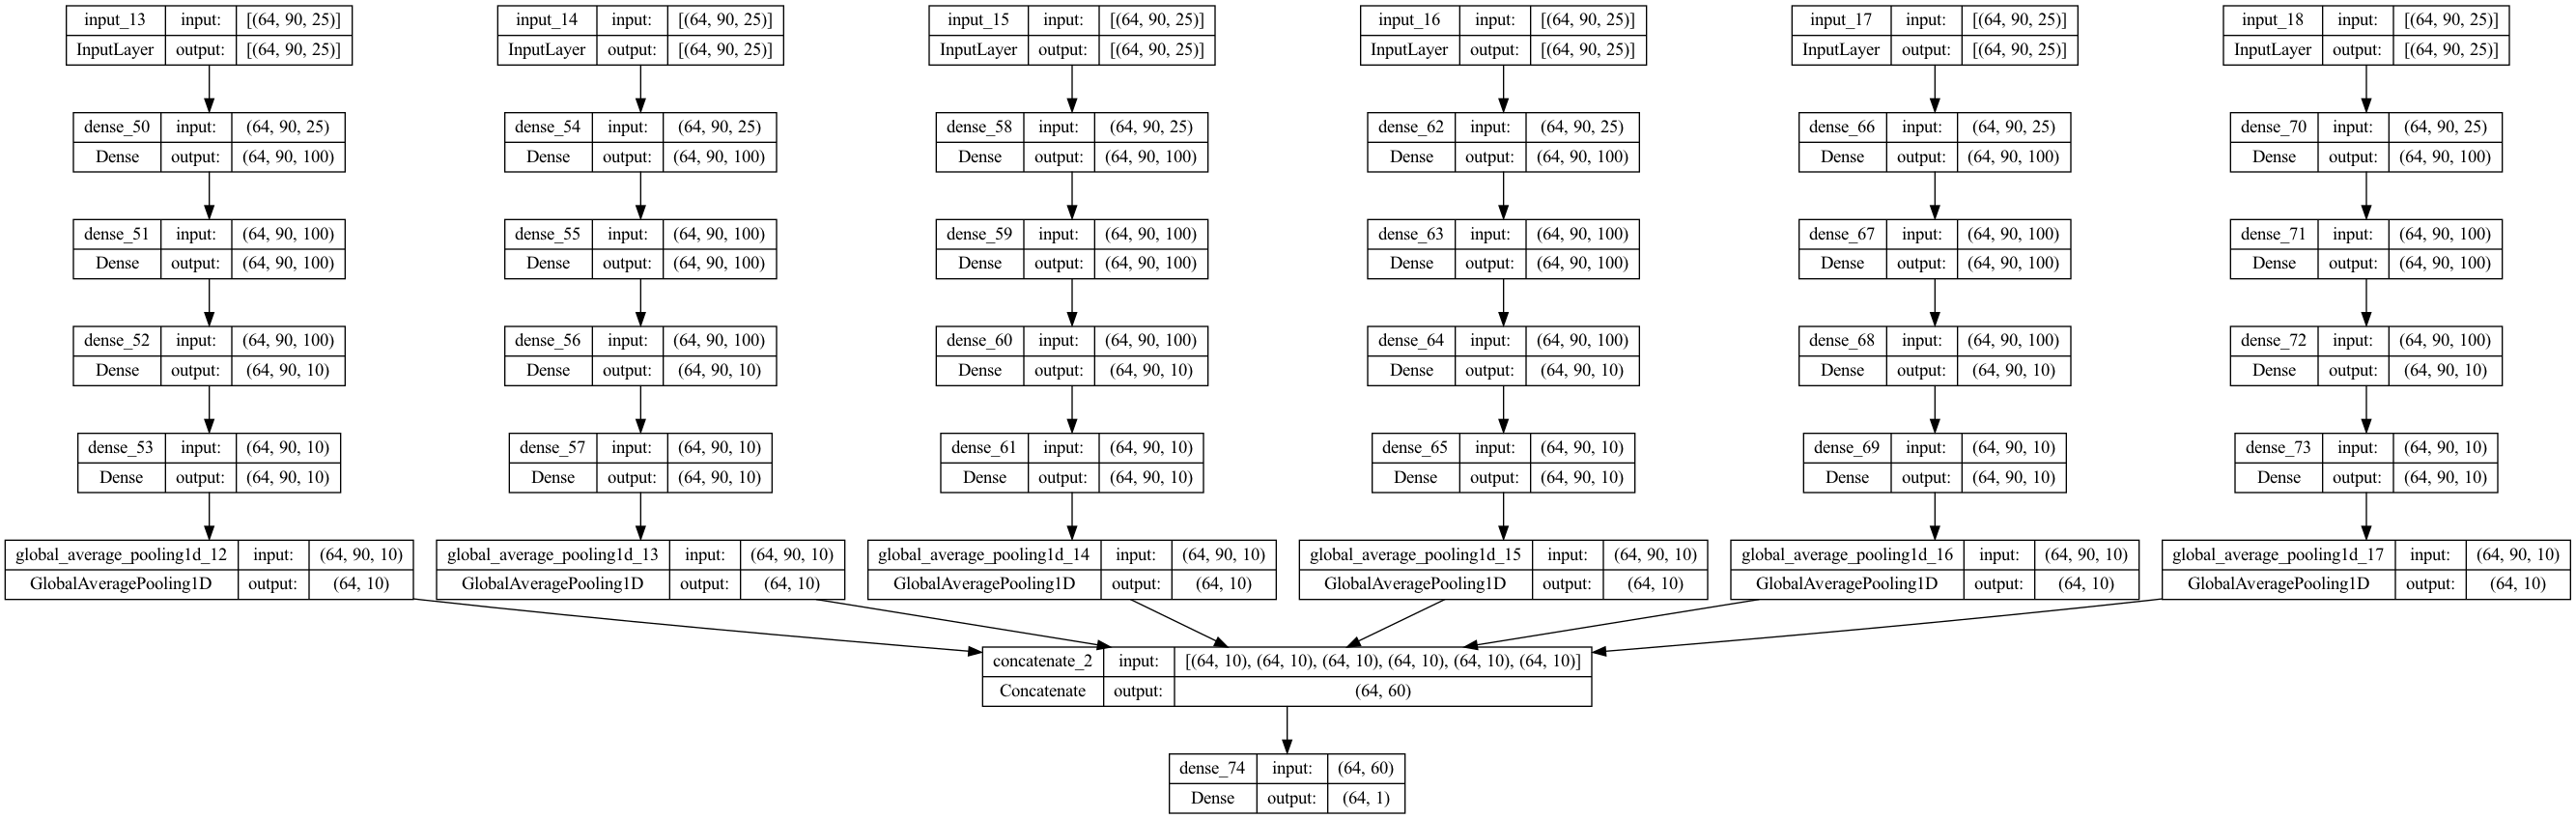

In [24]:
#model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/300
45/45 [==============================] - 4s 67ms/step - loss: 1534.6866 - mse: 3589438.2500 - val_loss: 888.3135 - val_mse: 1283485.0000
Epoch 2/300
45/45 [==============================] - 2s 44ms/step - loss: 823.0471 - mse: 1042108.1875 - val_loss: 843.5467 - val_mse: 951107.2500
Epoch 3/300
45/45 [==============================] - 2s 40ms/step - loss: 780.7059 - mse: 910672.0000 - val_loss: 821.9770 - val_mse: 1081366.3750
Epoch 4/300
45/45 [==============================] - 2s 41ms/step - loss: 687.6382 - mse: 754544.8750 - val_loss: 590.1517 - val_mse: 551977.0625
Epoch 5/300
45/45 [==============================] - 2s 40ms/step - loss: 490.1393 - mse: 426803.7812 - val_loss: 406.7525 - val_mse: 342809.7500
Epoch 6/300
45/45 [==============================] - 2s 39ms/step - loss: 350.0105 - mse: 220928.3125 - val_loss: 335.2472 - val_mse: 203335.6250
Epoch 7/300
45/45 [==============================] - 2s 40ms/step - loss: 332.3003 - mse: 199684.6406 - val_loss: 307.3

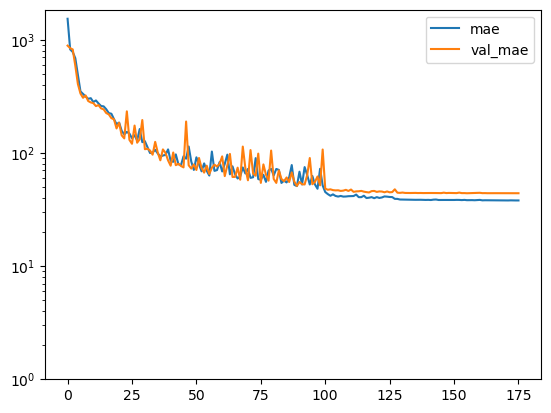

In [25]:
epochs = 300
lr = 1e-2

train_steps_per_epoch = len(X_train[0]) // batch_size

#lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)
lr_schedule = OneCycleScheduler(lr_max=lr, steps=train_steps_per_epoch, reduce_lr_patience=10, reduce_lr_factor=0.1)
lr_finder = LRFinder()

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights based on the monitored metric
)

# Define the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model_test.h5',  # Filepath to save the best model
    monitor='val_loss',  # Metric to monitor for saving the best model
    save_best_only=True  # Save only the best model based on the monitored metric
)

history = model.fit(X_train_1, y_train[:,1], epochs=epochs, validation_split=0.11111, verbose=1, batch_size=64,
                    callbacks=[lr_schedule, early_stopping, tensorboard_callback])

# Plot the training and validation loss and MAE
plt.semilogy(history.history['loss'], label='mae')
plt.semilogy(history.history['val_loss'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 0
plt.legend()
plt.show()

model.save('best_model_test_1.keras')

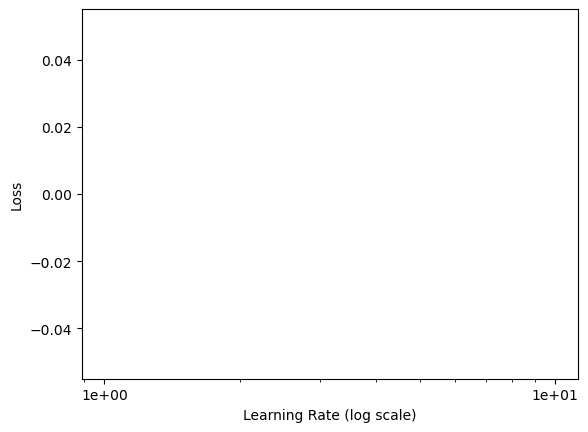

In [18]:
lr_finder.plot()

In [26]:
model = tf.keras.models.load_model('best_model_test_1.keras', compile=False)
model.optimizer = tf.keras.optimizers.legacy.Adam()
model.compile()

In [27]:
#model.load_weights('best_model_test_weight.h5')#tf.keras.models.load_model('best_model_test.keras')
primary_predictions = model.predict(X_train_1)
residuals_1 = y_train[:,0] - primary_predictions[:, 0]
abs(residuals_1).mean()

102/102 [==============================] - 2s 19ms/step


41.532402

# Secondary Model

In [28]:
X_train_2 = list(np.array(X_train)[:, :, :, cols_without_es_ym])
num_features_2 = X_train_2[0].shape[-1]

In [40]:
# Define the input layer
main_inputs = [

    Input(shape=(window_size, num_features_2), batch_size=batch_size),
    Input(shape=(window_size, num_features_2), batch_size=batch_size),
    Input(shape=(window_size, num_features_2), batch_size=batch_size),
    Input(shape=(window_size, num_features_2), batch_size=batch_size),
    Input(shape=(window_size, num_features_2), batch_size=batch_size),
    Input(shape=(window_size, num_features_2), batch_size=batch_size)

]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inp in zip(timeframes, main_inputs):
    x = Dense(100, activation='relu')(inp)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    conv_outputs.append(x)
    
# Concatenate the output
output = Concatenate(axis=1)(conv_outputs)
#output = GlobalAveragePooling1D()(output)
output = Dense(1)(output)

# Define the model with two outputs
secondary_model = Model(inputs=main_inputs, outputs=output)

# Compile the model
secondary_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mae', metrics=['mse'], run_eagerly=False)

In [43]:
#tf.keras.utils.plot_model(secondary_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/300
45/45 [==============================] - 6s 105ms/step - loss: 39.0482 - mse: 2851.9819 - val_loss: 42.6397 - val_mse: 3293.3765
Epoch 2/300
45/45 [==============================] - 2s 43ms/step - loss: 38.3882 - mse: 2779.4302 - val_loss: 44.0013 - val_mse: 3446.9207
Epoch 3/300
45/45 [==============================] - 2s 40ms/step - loss: 37.9899 - mse: 2711.3088 - val_loss: 42.7063 - val_mse: 3335.3147
Epoch 4/300
45/45 [==============================] - 2s 37ms/step - loss: 38.1080 - mse: 2736.0403 - val_loss: 43.7301 - val_mse: 3427.3274
Epoch 5/300
45/45 [==============================] - 2s 38ms/step - loss: 38.5556 - mse: 2786.7751 - val_loss: 44.3229 - val_mse: 3461.0864
Epoch 6/300
45/45 [==============================] - 2s 36ms/step - loss: 39.0327 - mse: 2837.4814 - val_loss: 44.3824 - val_mse: 3481.6355
Epoch 7/300
45/45 [==============================] - 2s 36ms/step - loss: 38.7590 - mse: 2788.6340 - val_loss: 42.9474 - val_mse: 3367.4646
Epoch 8/300
45/45 [

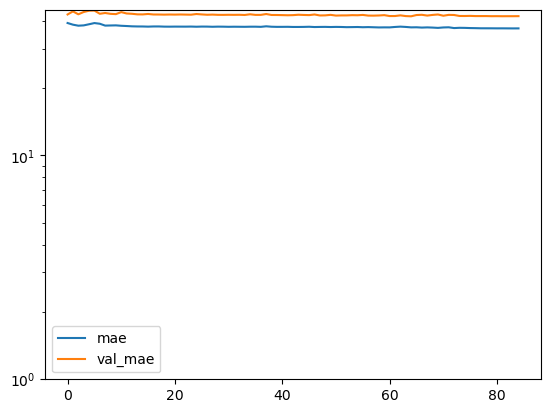

In [42]:
secondary_epochs = 300
lr = 1e-1

lr_schedule = OneCycleScheduler(lr_max=lr, steps=train_steps_per_epoch, reduce_lr_patience=10, reduce_lr_factor=0.1)

secondary_history = secondary_model.fit(X_train_2, residuals_1, epochs=secondary_epochs, validation_split=0.11111, verbose=1, batch_size=64,
                    callbacks=[lr_schedule, early_stopping])

# Plot the training and validation loss and MAE
plt.semilogy(secondary_history.history['loss'], label='mae')
plt.semilogy(secondary_history.history['val_loss'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 1
plt.legend()
plt.show()

secondary_model.save('best_model_test_2.keras')


In [44]:
secondary_model = tf.keras.models.load_model('best_model_test_2.keras', compile=False)
secondary_model.optimizer = tf.keras.optimizers.legacy.Adam()
secondary_model.compile()

In [45]:
secondary_predictions = secondary_model.predict(X_train_2)
residuals_2 = y_train[:,0] - (primary_predictions[:, 0] + secondary_predictions[:,0])
abs(residuals_2).mean()

102/102 [==============================] - 3s 25ms/step


37.79847

## Tertiary Model

In [46]:
X_train_3 = list(np.array(X_train)[:, :, :, cols_without_es_nq])
num_features_3 = X_train_3[0].shape[-1]

In [47]:
main_inputs = [

    Input(shape=(window_size, num_features_3), batch_size=batch_size),
    Input(shape=(window_size, num_features_3), batch_size=batch_size),
    Input(shape=(window_size, num_features_3), batch_size=batch_size),
    Input(shape=(window_size, num_features_3), batch_size=batch_size),
    Input(shape=(window_size, num_features_3), batch_size=batch_size),
    Input(shape=(window_size, num_features_3), batch_size=batch_size)

]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inp in zip(timeframes, main_inputs):
    x = Dense(100, activation='relu')(inp)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    conv_outputs.append(x)
    
# Concatenate the output
output = Concatenate(axis=1)(conv_outputs)
#output = GlobalAveragePooling1D()(output)
output = Dense(1)(output)

# Define the model with two outputs
tertiary_model = Model(inputs=main_inputs, outputs=output)

# Compile the model
tertiary_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mae', metrics=['mse'], run_eagerly=False)

In [48]:
#tf.keras.utils.plot_model(tertiary_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
secondary_epochs = 300
lr = 1e-2

lr_schedule = OneCycleScheduler(lr_max=lr, steps=train_steps_per_epoch, reduce_lr_patience=10, reduce_lr_factor=0.1)

tertiary_history = tertiary_model.fit(X_train_3, residuals_2, epochs=secondary_epochs, validation_split=0.11111, verbose=1, batch_size=64,
                    callbacks=[lr_schedule, early_stopping])

# Plot the training and validation loss and MAE
plt.semilogy(secondary_history.history['loss'], label='mae')
plt.semilogy(secondary_history.history['val_loss'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 1
plt.legend()
plt.show()

tertiary_model.save('best_model_test_3.keras')


Epoch 1/300
45/45 [==============================] - 6s 107ms/step - loss: 37.3000 - mse: 2653.8491 - val_loss: 41.8469 - val_mse: 3226.0376
Epoch 2/300
45/45 [==============================] - 2s 44ms/step - loss: 37.2914 - mse: 2652.4045 - val_loss: 41.8452 - val_mse: 3226.4290
Epoch 3/300
45/45 [==============================] - 2s 39ms/step - loss: 37.2912 - mse: 2653.8877 - val_loss: 41.8468 - val_mse: 3226.4104
Epoch 4/300
45/45 [==============================] - 2s 39ms/step - loss: 37.2972 - mse: 2653.6582 - val_loss: 41.8643 - val_mse: 3227.4099
Epoch 5/300
45/45 [==============================] - 2s 38ms/step - loss: 37.2821 - mse: 2651.9465 - val_loss: 41.9008 - val_mse: 3229.9346
Epoch 6/300
45/45 [==============================] - 2s 37ms/step - loss: 37.2970 - mse: 2653.5200 - val_loss: 41.8485 - val_mse: 3226.1189
Epoch 7/300
45/45 [==============================] - 2s 36ms/step - loss: 37.3117 - mse: 2656.1086 - val_loss: 41.8531 - val_mse: 3226.6990
Epoch 8/300
45/45 [

KeyboardInterrupt: 

In [36]:
tertiary_model = tf.keras.models.load_model('best_model_test_3.keras', compile=False)
tertiary_model.optimizer = tf.keras.optimizers.legacy.Adam()
tertiary_model.compile()

In [37]:
tertiary_predictions = tertiary_model.predict(X_train_3)
residuals_3 = y_train[:,0] - (primary_predictions[:, 0] + secondary_predictions[:,0] + tertiary_predictions[:, 0])
abs(residuals_3).mean()

102/102 [==============================] - 3s 25ms/step


5.976492

## Quaternary Model

In [39]:
X_train_4 = list(np.array(X_train)[:, :, :, cols_with_news])
num_features_4 = X_train_4[0].shape[-1]

In [40]:
# Define the input layer
main_inputs = [

    Input(shape=(window_size, num_features_4), batch_size=batch_size),
    Input(shape=(window_size, num_features_4), batch_size=batch_size),
    Input(shape=(window_size, num_features_4), batch_size=batch_size),
    Input(shape=(window_size, num_features_4), batch_size=batch_size),
    Input(shape=(window_size, num_features_4), batch_size=batch_size),
    Input(shape=(window_size, num_features_4), batch_size=batch_size)

]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inp in zip(timeframes, main_inputs):
    x = Dense(100, activation='relu')(inp)
    x = Dense(100, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = Dense(10, activation='relu')(x)
    x = GlobalAveragePooling1D()(x)
    conv_outputs.append(x)
    
# Concatenate the output
output = Concatenate(axis=1)(conv_outputs)
#output = GlobalAveragePooling1D()(output)
output = Dense(1)(output)

# Define the model with two outputs
quaternary_model = Model(inputs=main_inputs, outputs=output)

# Compile the model
quaternary_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), loss='mae', metrics=['mse'], run_eagerly=False)

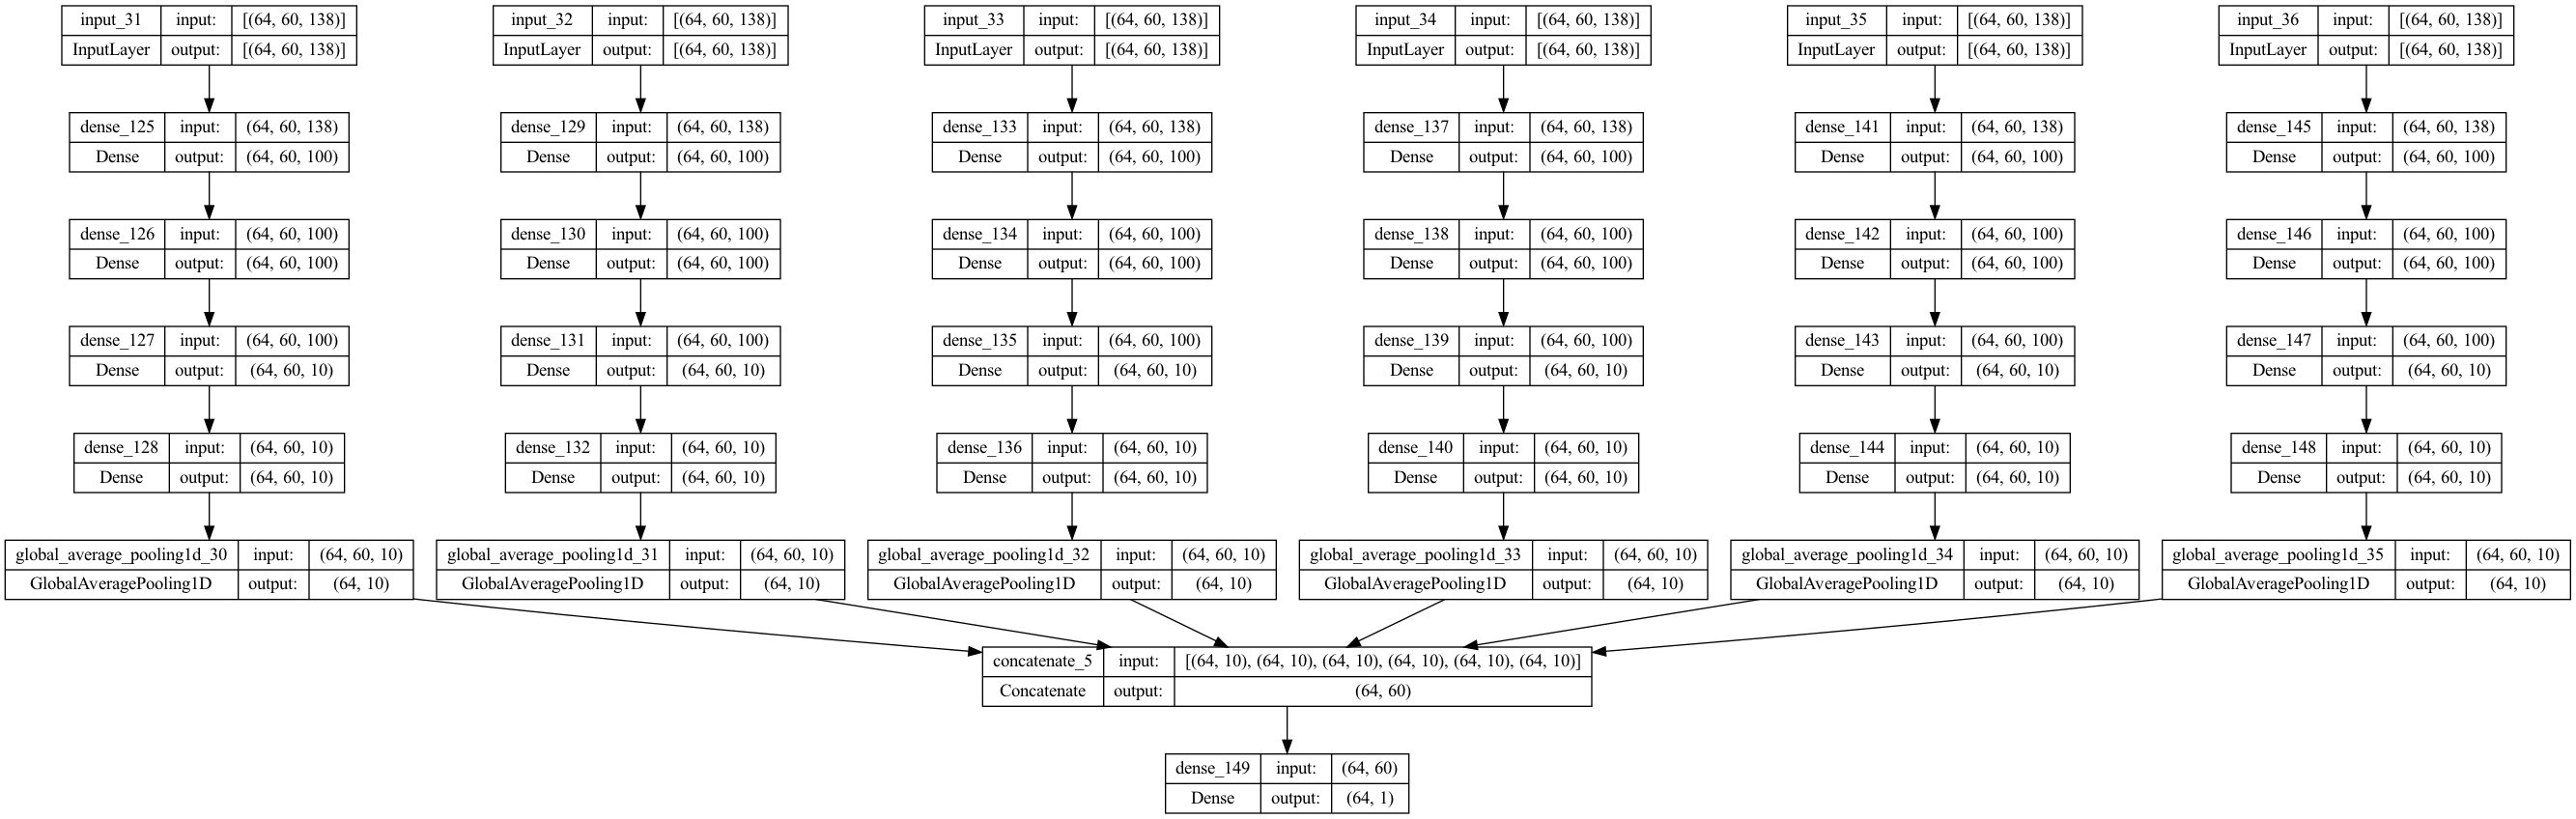

In [41]:
tf.keras.utils.plot_model(quaternary_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Epoch 1/300
46/46 [==============================] - 7s 109ms/step - loss: 5.6324 - mse: 220.2834 - val_loss: 8.7243 - val_mse: 206.0253
Epoch 2/300
46/46 [==============================] - 2s 44ms/step - loss: 5.6326 - mse: 220.3001 - val_loss: 8.7248 - val_mse: 206.1108
Epoch 3/300
46/46 [==============================] - 2s 44ms/step - loss: 5.6321 - mse: 220.2886 - val_loss: 8.7242 - val_mse: 206.0116
Epoch 4/300
46/46 [==============================] - 2s 44ms/step - loss: 5.6323 - mse: 220.2514 - val_loss: 8.7238 - val_mse: 205.9248
Epoch 5/300
46/46 [==============================] - 2s 39ms/step - loss: 5.6322 - mse: 220.2537 - val_loss: 8.7240 - val_mse: 205.9874
Epoch 6/300
46/46 [==============================] - 2s 41ms/step - loss: 5.6325 - mse: 220.2355 - val_loss: 8.7235 - val_mse: 205.8771
Epoch 7/300
46/46 [==============================] - 2s 38ms/step - loss: 5.6323 - mse: 220.2344 - val_loss: 8.7236 - val_mse: 205.8883
Epoch 8/300
46/46 [============================

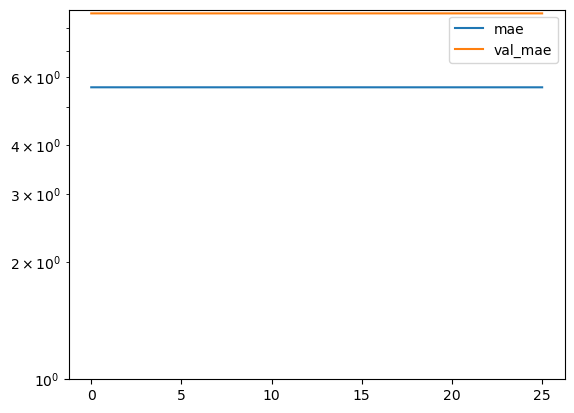

In [42]:
secondary_epochs = 300
lr = 1e-2

lr_schedule = OneCycleScheduler(lr_max=lr, steps=train_steps_per_epoch, reduce_lr_patience=10, reduce_lr_factor=0.1)

secondary_history = quaternary_model.fit(X_train_4, residuals_3, epochs=secondary_epochs, validation_split=0.11111, verbose=1, batch_size=64,
                    callbacks=[lr_schedule, early_stopping])

# Plot the training and validation loss and MAE
plt.semilogy(secondary_history.history['loss'], label='mae')
plt.semilogy(secondary_history.history['val_loss'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 1
plt.legend()
plt.show()

quaternary_model.save('best_model_test_4.keras')


In [43]:
quaternary_model = tf.keras.models.load_model('best_model_test_4.keras', compile=False)
quaternary_model.optimizer = tf.keras.optimizers.legacy.Adam()
quaternary_model.compile()

In [44]:
quaternary_predictions = quaternary_model.predict(X_train_4)
residuals_4 = y_train[:,0] - (primary_predictions[:, 0] + secondary_predictions[:,0] + tertiary_predictions[:, 0] + quaternary_predictions[:, 0])
abs(residuals_4).mean()

102/102 [==============================] - 3s 27ms/step


5.9764853

## Model Testing

In [68]:
# Reshape X_train to a np array
X_test = np.asarray(X_test)

# only get columns we want to standardize
cols_to_standardize = [c for c in df_1B.columns if any([s in c for s in ['open', 'high', 'low', 'close']])]
cols_to_standardize = [df_1B.columns.get_loc(c) for c in cols_to_standardize]
a = X_test[:,:,:,cols_to_standardize]

# Fit the scaler to the data and transform X_train
X_test[:,:,:,cols_to_standardize] = scaler.transform(a.reshape((-1, a.shape[-1]))).reshape(a.shape)

X_test = np.split(X_test, 6, axis=1)
X_test = [element.squeeze(axis=1) for element in X_test]

In [69]:
X_test_1 = list(np.array(X_test)[:, :, :, cols_without_nq_ym])
X_test_2 = list(np.array(X_test)[:, :, :, cols_without_es_ym])
X_test_3 = list(np.array(X_test)[:, :, :, cols_without_es_nq])
X_test_4 = list(np.array(X_test)[:, :, :, cols_with_news])

In [77]:
primary_predictions = model.predict(X_test_1)[:, 0]
secondary_predcitions = secondary_model.predict(X_test_2)[:, 0]
tertiary_predictions = tertiary_model.predict(X_test_3)[:, 0]
quaternary_predictions = quaternary_model.predict(X_test_4)[:, 0]

residuals_4 = y_test[:,0] - (primary_predictions + secondary_predictions + tertiary_predictions + quaternary_predictions)
abs(residuals_4).mean()

12/12 [==============================] - 0s 21ms/step


16.49141

In [79]:
df_1B.columns.tolist()

['open_es',
 'high_es',
 'low_es',
 'close_es',
 'swing_1B_es',
 'fair_value_gap_1B_es',
 'open_nq',
 'high_nq',
 'low_nq',
 'close_nq',
 'swing_1B_nq',
 'fair_value_gap_1B_nq',
 'open_dx',
 'high_dx',
 'low_dx',
 'close_dx',
 'swing_1B_dx',
 'fair_value_gap_1B_dx',
 'open_ym',
 'high_ym',
 'low_ym',
 'close_ym',
 'swing_1B_ym',
 'fair_value_gap_1B_ym',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'hour_sin',
 'hour_cos',
 'minute_sin',
 'minute_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'weekly_open',
 'weekly_close',
 'daily_open',
 'news_10-y Bond Auction',
 'news_30-y Bond Auction',
 'news_ADP Non-Farm Employment Change',
 'news_Advance GDP Price Index q/q',
 'news_Advance GDP q/q',
 'news_Assist Treasury Sec Kashkari Speaks',
 'news_Average Hourly Earnings m/m',
 'news_Bank Stress Test Results',
 'news_Beige Book',
 'news_Building Permits',
 'news_Business Inventories m/m',
 'news_CB Consumer Confidence',
 'news_CB Leading Index m/m',
 'news_CPI m/m',
 'news_CPI y/y',


In [21]:
# Generate predictions for the test set
morning_high_model = tf.keras.models.load_model('best_model_high.keras', compile=False)
morning_high_model.optimizer = tf.keras.optimizers.legacy.Adam()
morning_high_model.compile()

morning_low_model = tf.keras.models.load_model('best_model_low.keras', compile=False)
morning_low_model.optimizer = tf.keras.optimizers.legacy.Adam()
morning_low_model.compile()

morning_high_predictions = morning_high_model.predict(X_test)
morning_low_predictions = morning_low_model.predict(X_test)

# Create a dictionary with the arrays
data = {
    'date': pd.to_datetime(df_1T.iloc[data_indices].index.date[indices][split_index:]),
    'p_morning_high': morning_high_predictions.reshape(len(morning_high_predictions)),
    'morning_high': y_test[:,0].reshape(len(y_test[:,0])),
    'p_morning_low': morning_low_predictions.reshape(len(morning_low_predictions)),
    'morning_low': y_test[:,1].reshape(len(y_test[:,1])),
    'daily_high': y_test[:,4].reshape(len(y_test[:,4])),
    'daily_low': y_test[:,5].reshape(len(y_test[:,5])),
}

# Convert the dictionary to a DataFrame
res = pd.DataFrame(data).set_index('date').astype(float).round(2)
res['dh'] = res.morning_high - res.p_morning_high
res['dl'] = res.p_morning_low - res.morning_low

dates = [(d.strftime('%Y-%m-%d 09:30:00'), d.strftime('%Y-%m-%d 12:00:00')) for d in res.index.date]
high_first = []
for d in dates:
    high_first.append(df_1T.loc[d[0]: d[1]].high_es.idxmax() < df_1T.loc[d[0]: d[1]].low_es.idxmin())
res['high_first'] = high_first
    
res = res[res.index.year >= 2022]

# Print the individual predictions with actual values
# for i in range(len(predicted_high)):
#     print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")

12/12 [==============================] - 1s 75ms/step


In [40]:
sl = np.arange(1, int(res[['dl', 'dh']].abs().mean().mean()))
rr = np.arange(1, int(res[['dl', 'dh']].abs().mean().mean()))

results = []
total_taken = res[((res.dh > 0) & (res.high_first)) | ((res.dl > 0) & (~res.high_first))].shape[0] #only count the trades taken (where the p comes before the actual, i.e. ignore where the actual doesnt hit the p)

for i in sl:
    for j in rr:        
        longs_won = res[(res.dl < i) & (res.dl >= 0) & (res.daily_high >= res.p_morning_low + j * i) & res.high_first].shape[0]
        shorts_won = res[(res.dh < i) & (res.dh >= 0) & (res.daily_low <= res.p_morning_high - j * i) & (~res.high_first)].shape[0]
        total_return = (longs_won + shorts_won) * j - (total_taken - longs_won - shorts_won)
        prob_win = (longs_won + shorts_won) / total_taken
        result = {'sl': i, 
                  'rr': j, 
                  'total_taken': total_taken, 
                  'longs_won': longs_won, 
                  'shorts_won': shorts_won, 
                  'total_return': total_return,
                  'prob_win': prob_win
                 }
        results.append(result)
        
t = pd.DataFrame(results)
#t = t[(t.total_return > 0) & (t.prob_win > .5)]


In [39]:
res[((res.dh > 0) & (res.high_first)) | ((res.dl > 0) & (~res.high_first))]

,p_morning_high,morning_high,p_morning_low,morning_low,daily_high,daily_low,dh,dl,high_first
date,,,,,,,,,
2022-08-23,4235.71,4248.69,4195.17,4213.73,4248.69,4211.18,12.98,-18.56,True
2022-02-10,4645.91,4667.88,4608.36,4601.66,4667.88,4560.14,21.97,6.70,False
2022-12-13,4144.71,4174.92,4108.45,4086.95,4174.92,4059.23,30.21,21.50,True
2022-07-01,3890.62,3896.49,3833.56,3831.92,3913.59,3831.92,5.87,1.64,True
2022-03-28,4635.51,4640.97,4600.07,4606.26,4665.73,4603.96,5.46,-6.19,True
2022-11-21,4034.03,4035.83,4001.88,4002.29,4035.83,4002.29,1.80,-0.41,True
2022-07-21,4061.83,4057.02,4021.75,4012.36,4087.90,4012.36,-4.81,9.39,False
2022-04-11,4552.31,4552.66,4507.28,4517.95,4552.66,4495.49,0.35,-10.67,True
2022-11-04,3864.87,3868.11,3812.11,3785.02,3868.11,3776.38,3.24,27.09,True


In [33]:
t.sort_values(['total_return', 'prob_win'], ascending=[False, False])

,sl,rr,total_taken,longs_won,shorts_won,total_return,prob_win
29,2,15,15,1,1,17,0.133333
28,2,14,15,1,1,15,0.133333
27,2,13,15,1,1,13,0.133333
26,2,12,15,1,1,11,0.133333
25,2,11,15,1,1,9,0.133333
...,...,...,...,...,...,...,...
220,15,11,15,0,0,-15,0.000000
221,15,12,15,0,0,-15,0.000000
222,15,13,15,0,0,-15,0.000000
223,15,14,15,0,0,-15,0.000000


In [33]:
import mplfinance as mpf

In [48]:
temp = df_5T.loc['2022-07-25 03:00':'2022-07-26 09:30'].rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).astype('float32')#df.resample('1B').agg(keep_cols['1B']).dropna().convert_dtypes()


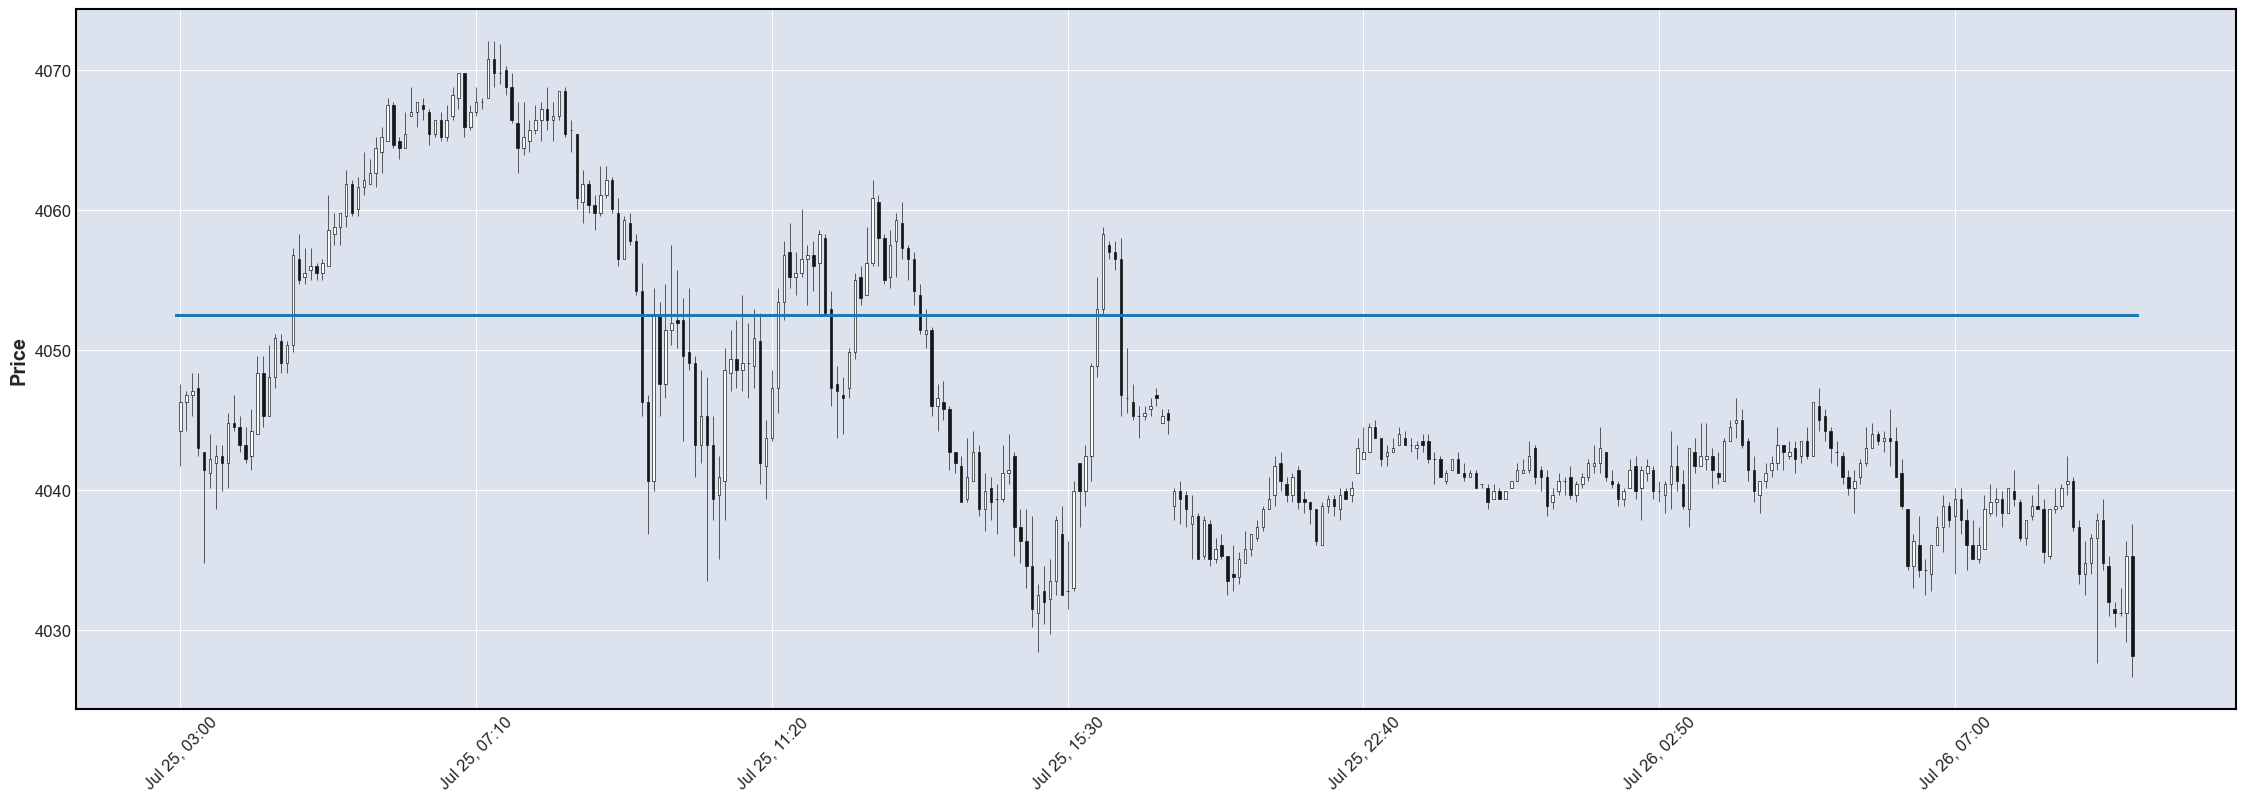

In [49]:
mpf.plot(temp, type='candle', figsize=(30,10), hlines=[4052.54])

In [134]:
res

,p_morning_high,morning_high,p_morning_low,morning_low,daily_high,daily_low,dh,dl
date,,,,,,,,
2022-09-27,3797.29,3794.42,3740.99,3725.56,3794.42,3695.06,-2.87,15.43
2022-12-15,4034.99,4017.89,3995.59,3949.08,4017.89,3940.01,-17.10,46.51
2022-07-26,4049.93,4037.62,4006.79,3999.34,4037.62,3995.00,-12.31,7.45
2022-08-23,4242.53,4248.69,4190.22,4213.73,4248.69,4211.18,6.16,-23.51
2022-12-20,3896.74,3897.41,3840.58,3853.56,3898.17,3853.56,0.67,-12.98
2022-04-22,4498.08,4472.01,4449.94,4400.04,4472.01,4350.78,-26.07,49.90
2023-04-24,4166.13,4164.25,4141.29,4141.00,4164.25,4139.00,-1.88,0.29
2022-07-29,4177.39,4209.39,4157.54,4166.26,4230.57,4166.26,32.00,-8.72
2023-01-23,4044.85,4084.18,4025.52,4018.90,4089.98,4018.90,39.33,6.62
